# Testing Slope Fitting on Synthetic PSDs

In [1]:
# This notebook uses py2.7 - because that's what FOOF is written in
from __future__ import print_function, division

In [2]:
# Bayes FOOF has a dependency of sklearn version >= 0.18.0. Check this.
import sklearn
assert sklearn.__version__[:4] == '0.18'

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Custom code imports
#  NOTE: Currently, settings in slf.fit will set which FOOF to use
from slf.fit import *
from foof import syn

## Check out PSD generation and test fitting

In [5]:
# Generate a single synthetic PSD

slv_test = 1.0

fs, psd = syn.mfonef(
    mf=[20],
    mf_sig=[2],
    mk=[0.2],
    chi=slv_test,
    f0=3,
    fmax=40,
    res=0.5,
    noi=0.05
)

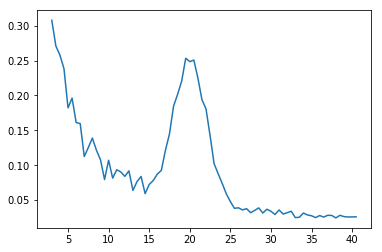

In [6]:
# Check plot of the synthetic PSD - linear space
plt.plot(fs, psd)

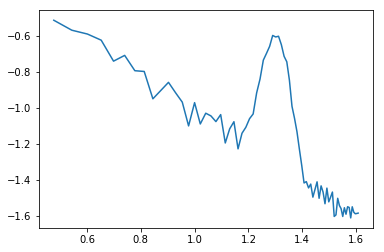

In [7]:
# Check plot of the synthetic PSD - log space
plt.plot(np.log10(fs), np.log10(psd))

In [8]:
# Check foof fit on synthetic data
from slf.fit import _foof_fit

In [9]:
#fs = np.reshape(fs, [len(fs), 1])
psd = np.reshape(psd, [len(fs), 1])
_foof_fit(fs, psd)

(0.97185039298478215,
 array([ 19.3204703 ,  22.30499373]),
 array([ 0.25326997,  0.14260014]),
 array([ 1.7052196 ,  1.26827562]))

In [10]:
# Test out fits
print('True slope value is ', str(slv_test), '\n')
print('RLM fit: \t', fsl_rlm(fs, psd))
print('RLM-EA fit: \t', fsl_rlm_alph(fs, psd))
print('RLM-EO fit: \t', fsl_rlm_oscs(fs, psd))
print('RAN fit: \t', fsl_ransac(fs, psd))
print('RAN-EA fit: \t', fsl_ransac_alph(fs, psd))
print('RAN-EO fit: \t', fsl_ransac_oscs(fs, psd))

True slope value is  1.0 

RLM fit: 	 -0.977653007468
RLM-EA fit: 	 -1.01386390612
RLM-EO fit: 	 -0.993859445641
RAN fit: 	 -0.971850392985
RAN-EA fit: 	 -1.00467520061
RAN-EO fit: 	 -0.989366549905


## Run a bunch of synthetic fits

In [11]:
# Settings for syn data generation and slope fitting
slv = 1
n_psds = 10

In [12]:
# Synthesize data
fs, psds = syn.synthesize(n_psds, fn=syn.mfonef, 
                          mf=[10], mf_sig=[1], mk=[0.2], chi=slv, 
                          f0=3, fmax=40, res=0.5, noi=0.05)

In [13]:
# Initialize stuff for synthetic data fitting runs

# NOTE: This is almost definitely a terrible way to organize these runs. 
#  TODO: Fix this shit. 

fit_funcs = {'RLM': fsl_rlm, 
             'RLM-EA': fsl_rlm_alph, 
             'RLM-EO': fsl_rlm_oscs, 
             'RAN': fsl_ransac,
             'RAN-EA': fsl_ransac_alph,
             'RAN-EO': fsl_ransac_oscs}

errs = dict()
for key in fit_funcs.keys():
    errs[key] = np.zeros(n_psds)

In [14]:
# Fit slope and collect error
for k, fn in fit_funcs.items():
    for i in range(n_psds):
        errs[k][i] = sqd_err(-slv, fn(fs, psds[:, i]))

In [15]:
# Calculate mean errors per method
avg_errs = []
for k, v in errs.items():
    avg_errs.append((np.median(v), k))
avg_errs.sort()

In [16]:
# Print out errors per method
for ae in avg_errs:
    print(ae[1], '\t', ae[0])

RLM-EA 	 0.000197716452377
RAN-EA 	 0.000250407838229
RLM-EO 	 0.000312488433368
RAN-EO 	 0.000330916659075
RAN 	 0.000735202956461
RLM 	 0.0027542332238


## Check Error Distributions

In [17]:
from slf.fake import *

In [18]:
syns = SynFits()
syns.get_fit_funcs()

#
n_psds = 100
slv = 1

fs, psds = mk_psds(n_psds, slv)

#
syns.fit_slopes(slv, fs, psds)
mes = syns.calc_mean_errs()

print_errs(mes)



RLM-EA 		 0.0156244080473
RLM-EO 		 0.015842552539
RAN-EO 		 0.0177304026787
RAN-EA 		 0.0189349069289
RAN 		 0.0241431384536
RLM 		 0.0487715207891




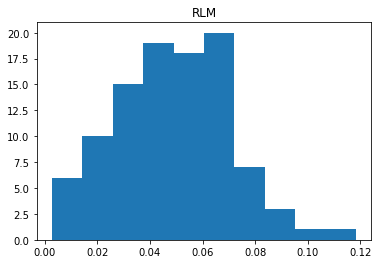

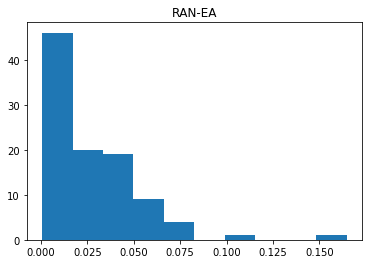

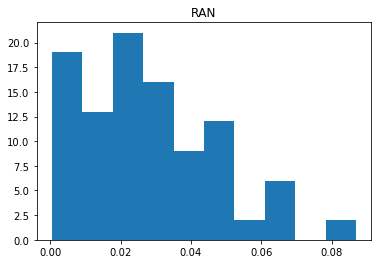

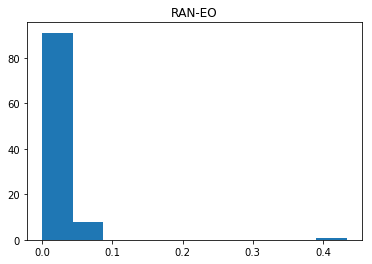

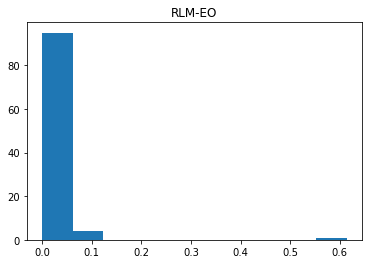

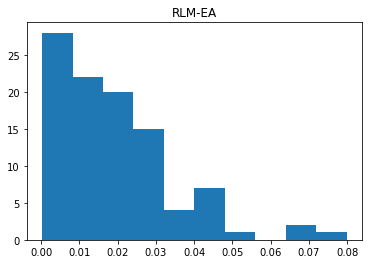

In [20]:
for meth in syns.errs.keys():
    #print(meth)
    plt.figure()
    plt.hist(syns.errs[meth])
    plt.title(meth)
    #plt.xlim([0, 0.02])

In [34]:
for meth in syns.errs.keys():
    print(meth, '\t', sum(syns.errs[meth] < 0.025) / len(syns.errs[meth]))

RLM 	 0.16
RAN-EA 	 0.59
RAN 	 0.52
RAN-EO 	 0.66
RLM-EO 	 0.74
RLM-EA 	 0.72


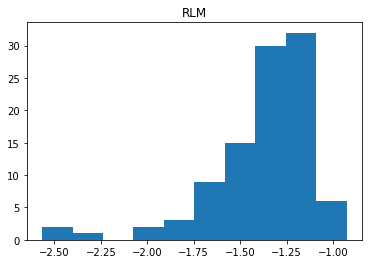

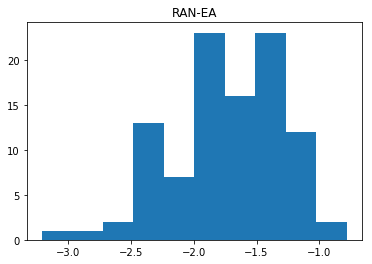

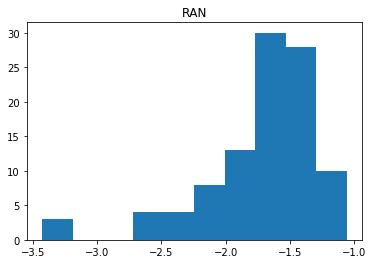

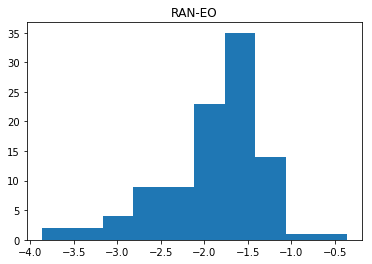

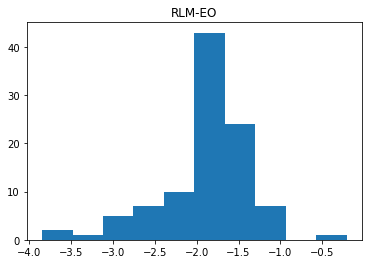

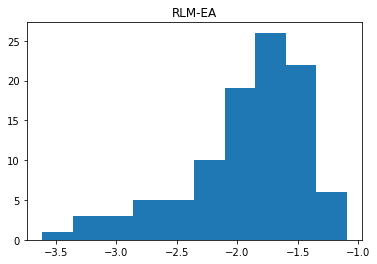

In [63]:
for meth in syns.errs.keys():
    plt.figure()
    plt.hist(np.log10(syns.errs[meth]))
    plt.title(meth)

In [23]:
for meth in syns.errs.keys():
    print(np.mean(syns.errs[meth]))

0.0482149185356
0.0272651776425
0.027713473973
0.0247296601541
0.0259219880687
0.0191125039255


In [24]:
for meth in syns.errs.keys():
    print(np.median(syns.errs[meth]))

0.0487715207891
0.0189349069289
0.0241431384536
0.0177304026787
0.015842552539
0.0156244080473


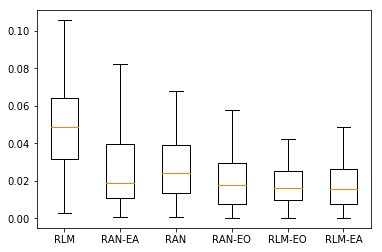

In [35]:
_ = plt.boxplot([syns.errs[meth] for meth in syns.errs.keys()],
                labels=syns.errs.keys(),
                showfliers=False)

## Statistically Compare Methods

In [62]:
from scipy.stats import ranksums

In [58]:
comps = np.zeros([len(syns.errs), len(syns.errs)])
for ii, ki in enumerate(syns.errs.keys()):
    for ij, kj in enumerate(syns.errs.keys()):
        s, p = ranksums(syns.errs[ki], syns.errs[kj])
        comps[ii, ij] = p

In [59]:
import pandas as pd

In [60]:
df = pd.DataFrame(comps, index=syns.errs.keys(), columns=syns.errs.keys())

In [64]:
# Use colours to get an eye on significant differences
def _color_red_or_green(val):
    color = 'green' if val < 0.05 else 'red'
    return 'color: %s' % color
df.style.applymap(_color_red_or_green)

In [ ]:
from scipy.stats.mstats import normaltest

In [ ]:
for meth in syns.errs.keys():
    a, b = normaltest(np.log10(syns.errs[meth]))
    print(a, '\t', b)